# MagNet: Model the Geomagnetic Field:
This notebook provides a TAI4ES Summer School learning journey using the benchmark LSTM model from the NOAA MagNet challenge. You'll want to open up our space weather use case README as well as sibling notebook magnet_cnn_tutorial.ipynb inside your prepared environment. You can find the latest materials in our [space weather TAI4ES github folder](https://github.com/ai2es/tai4es-trustathon-2022/tree/main/space).

## Goal: Learn about ML modeling a key space weather storm indicator <i>Dst</i>

The overall goal is to learn about ML modeling a key space weather storm indicator, the disturbance storm-time (<i>Dst</i>) index.

We will use two space weather <i>Dst</i> notebooks throughout your summer school experience:
* magnet_lstm_tutorial.ipynb - ideal for students newer to AI/ML
* magnet_cnn_tutorial.ipynb - ideal for students with more AI/ML experience

Use the space weather README to guide your experience.

In this notebook, you'll notice color-coded boxes, which may provide optional tasks, questions to discuss, or warnings. Here is the color-coding breakdown: 
* <span style="color:blue">Blue Box</span> = Question to discuss
* <span style="color:red">Red Box</span> = Warning/Caution
* <span style="color:gold">Yellow Box</span> = Optional task to perform 
* <span style="color:green">Green Box</span> = Useful Tip or Reminder

## Background on Geospace Space Weather

Just like the terrestrial weather we are used to experiencing in our daily lives, weather also occurs in the space environment. If you'd like a general primer on space weather and it's effects on the technological systems we rely on, check out [NASA's Space Place](https://spaceplace.nasa.gov/spaceweather/), as well as [NOAA's Space Weather Prediction Center (SWPC)](https://www.swpc.noaa.gov/), in particular their community dashboards.

![HELIO_GRAPHIC_URL](https://ngdc.noaa.gov/geomag/img/challenge-banner.png "HELIO")

## Background on the Geomagnetic Field

The efficient transfer of energy from solar wind into the Earth’s magnetic field causes geomagnetic storms. The resulting variations in the magnetic field increase errors in magnetic navigation. The disturbance-storm-time index, or <i>Dst</i>, is a measure of the severity of the geomagnetic storm.

As a key specification of the magnetospheric dynamics, the <i>Dst</i> index is used to drive geomagnetic disturbance models such as NOAA/NCEI’s High Definition Geomagnetic Model - Real-Time (HDGM-RT).
![HDGMRT_GRAPHIC_URL](https://www.ngdc.noaa.gov/geomag/HDGM/images/HDGM-RT_2003_storm_720p.gif "HDGM-RT")
 
In 2020-2021, NOAA and NASA conducted an international crowd sourced data science competition “MagNet: Model the Geomagnetic Field”:
https://www.drivendata.org/competitions/73/noaa-magnetic-forecasting/
 
Empirical models have been proposed as early as in 1975 to forecast <i>Dst</i> solely from solar-wind observations at the Lagrangian (L1) position by satellites such as NOAA’s Deep Space Climate Observatory (DSCOVR) or NASA's Advanced Composition Explorer (ACE). Over the past three decades, several models were proposed for solar wind forecasting of <i>Dst</i>, including empirical, physics-based, and machine learning approaches. While the ML models generally perform better than models based on the other approaches, there is still room to improve, especially when predicting extreme events. More importantly, we intentionally sought solutions that work on the raw, real-time data streams and are agnostic to sensor malfunctions and noise.

## Modeling Task

The MagNet competition task was to develop models for forecasting <i>Dst</i> that push the boundary of predictive performance, under operationally viable constraints, using the real-time solar-wind (RTSW) data feeds from NOAA’s DSCOVR and NASA’s ACE satellites. Improved models can provide more advanced warning of geomagnetic storms and reduce errors in magnetic navigation systems. Specifically, given one week of data ending at t minus 1 minute, the model must forecast <i>Dst</i> at time t and t plus one hour.

The model described in this notebook is the benchmark model provided by the MagNet competition organizers. Long Short Term Memory networks or LSTMs are a special kind of recurrent neural network especially suited to time series data. In the related notebook, we will show you how to implement a first-pass LSTM model for predicting <i>Dst</i>.

<div class="alert alert-block alert-info">
<b>Question: </b> Can you describe the physical process between solar wind and ground geomagnetic disturbances? What is the <i>Dst</i> index primarily used for?
Roughly 85% of the time, near Earth is geomagnetically quiet. How might these infrequent solar wind events make modeling their predicted effects challenging? How might you make an accurate model with very few extreme events/samples?
</div>

<div class="alert alert-block alert-info">
<i>You can use this empty cell to write down your thoughts regarding the preceding question(s).</i>
</div>

## Data Notes

The target <i>Dst</i> values are measured by 4 ground-based observatories near the equator. These values are then averaged to provide a measurement of <i>Dst</i> for any given hour.
To ensure similar distributions between the training and test data, the data is separated into three non-contiguous periods. All data are provided with a `period` and `timedelta` multi-index which indicates the relative timestep for each observation within a period, but not the real timestamp. The period identifiers and timedeltas are common across datasets. Converting back from our index date and time to real geophysical date and time as simple as adding the the start date/time in the table below to the relative timestep provided with the data.

Table: Dataset Period Time Ranges

| Period  | Beginning               | End                      |
|---------|-------------------------|--------------------------|
| train_a | 1998, 2, 16, '00:00:00' |  2001, 5, 31, '23:00:00' |
| train_b |  2013, 6, 1, '00:00:00' |  2017, 7, 31, '23:00:00' |
| train_c | 2004, 10, 1, '00:00:00' |  2010, 1, 31, '23:00:00' |
|  test_a |  2001, 6, 1, '00:00:00' |  2004, 9, 30, '23:00:00' |
|  test_b |  2010, 2, 1, '00:00:00' |  2013, 5, 31, '23:00:00' |
|  test_c |  2017, 8, 1, '00:00:00' | 2020, 10, 31, '23:00:00' |


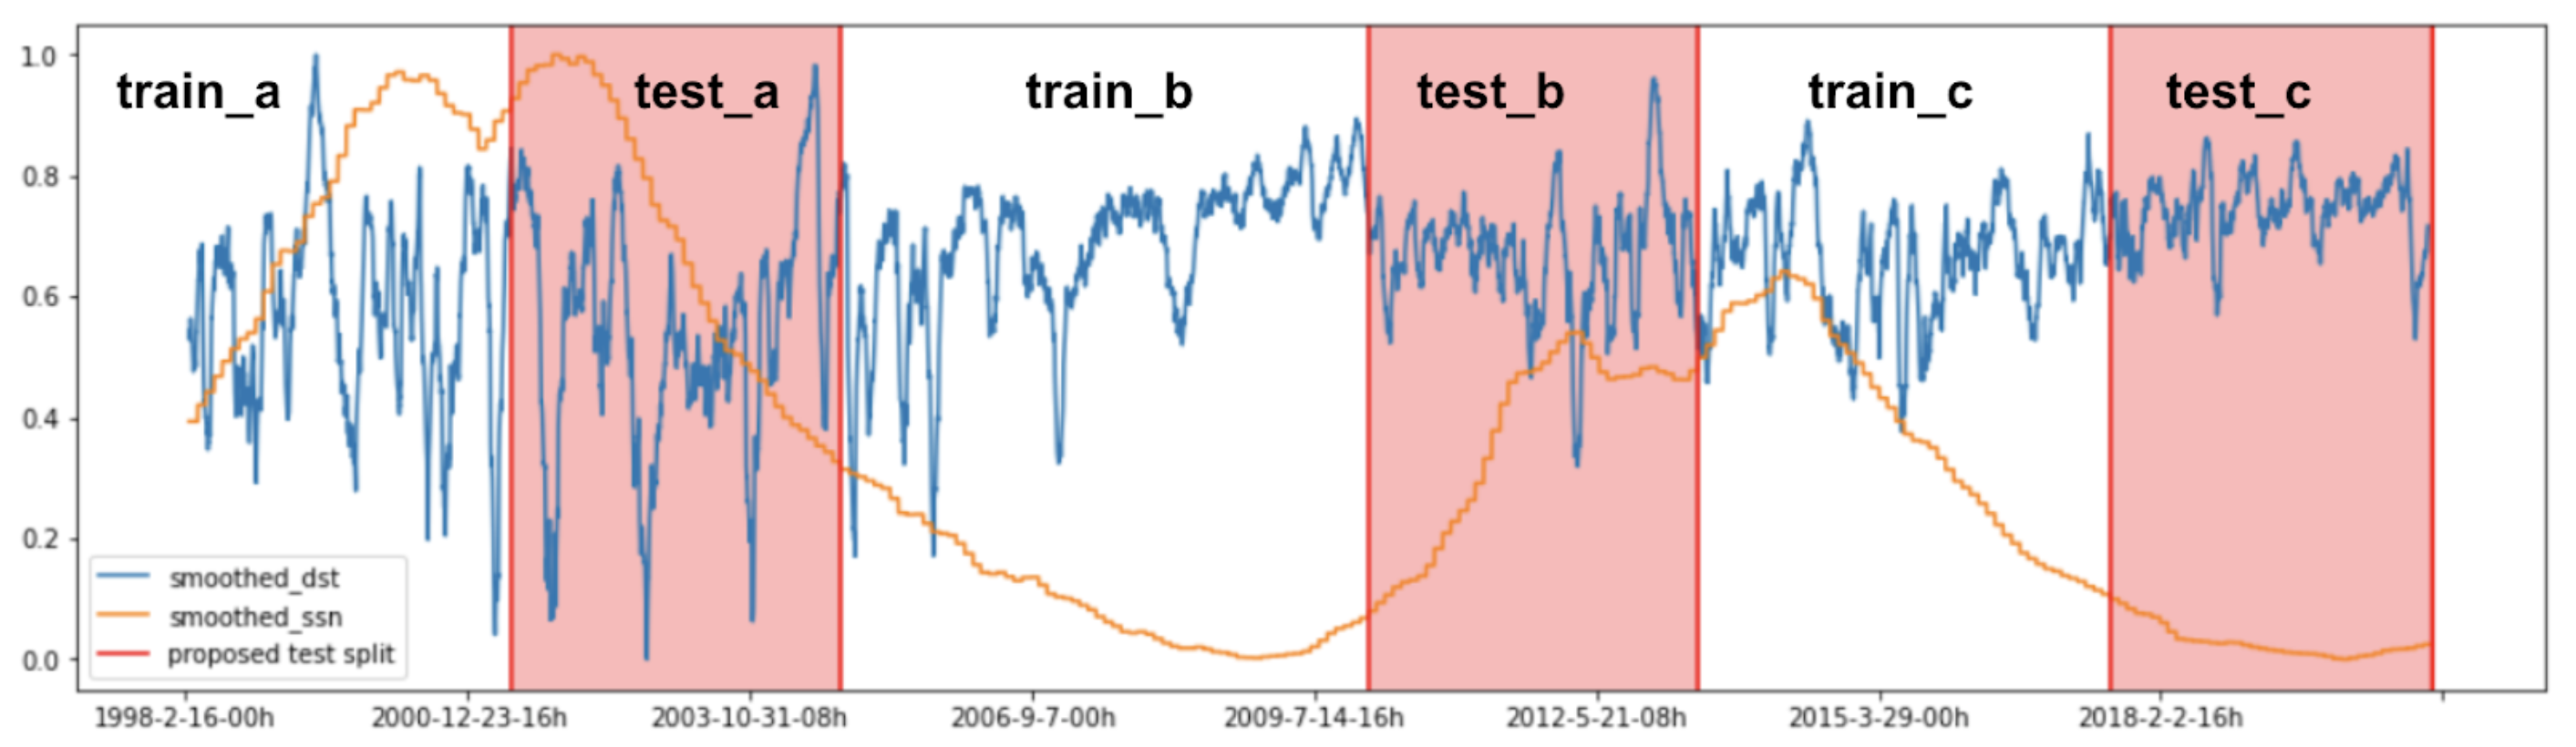
<i>Figure: Plot shows solar activity as the sunspot number (SSN) (orange), the geomagnetic storm index Dst (blue), and the public and private data segments (red shaded).  SSN and Dst have been normalized. The time range shown is January 1998 through December 2022. This figure and the table preceeding it have been adapted from Manoj et al. (manuscript in preparation).</i>

The competitors used the training part (“train_a”,”train_b” and “train_c”) data to develop and improve their models. When they submitted a model, the competition platform used the test data sets (“test_a”,”test_b” and “test_c”)  to calculate the accuracy of the model. The model evaluation was done separately for a public leaderboard and for a private leaderboard. The public leaderboard was openly accessible whereas the private leaderboard was restricted to the competition administrators. The  data from all of the training sets (a, b, and c) were used on the public leaderboard and private leaderboard. We randomly sampled rows to be included in the public and private leaderboard. Based on relative performance from the public leaderboard as a clue, the teams iterated their models. The final ranking of the models was done on the private leaderboard.

### Input (feature) data sources - there are 3:
* Satellite measurements of the solar wind, including direction, speed, density and temperature, at 1-minute cadence.
* Position of the satellite used for solar wind measurements. The ACE and DSCOVR satellites are positioned just outside Earth's exosphere approximately 1% of the distance from Earth to Sun. As noted above, this is referred to as the Sun Earth L1 position.
* Number of sunspots on the Sun, measured monthly.

Here is a description of several of these inputs (features) observed by the ACE or DSCOVR satellites (see [here](https://www.drivendata.org/competitions/73/noaa-magnetic-forecasting/page/279/) for the full list):

<div class="alert alert-block alert-success">

* bt - Interplanetary-magnetic-field magnitude (nT)
* bx_gsm - Interplanetary-magnetic-field X-component in geocentric solar magnetospheric (GSM) coordinate (nT)
* by_gsm - Interplanetary-magnetic-field Y-component in GSM coordinate (nT)
* bz_gsm - Interplanetary-magnetic-field Z-component in (GSM) coordinate (nT)
* density - Solar wind proton density (N/cm^3)
* speed - Solar wind bulk speed (km/s) flowing from Sun to Earth
* temperature - Solar wind ion temperature (Kelvin)
</div>

To get a feeling for the GSM coordinate reference frame:

The X-axis is oriented from the Earth to the Sun. The positive Z-axis is chosen to be in the same sense as the northern magnetic pole. And the Y-axis is defined to be perpendicular to the Earth's magnetic dipole so that the X-Z plane contains the dipole axis. For additional details, see [here](https://www.spenvis.oma.be/help/background/coortran/coortran.html#GSM).

To see how several of these parameter look during an example space weather event see [Figure 5](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2018SW001897#swe20716-fig-0005) of Redmon et al., 2018.

## Acknowledgements:

Author: Rob Redmon

Points of contact: Rob.Redmon@noaa.gov, Manoj.C.Nair@noaa.gov

Topics on Explainable AI (XAI) (e.g. Feature Importance, Case Studies) are new and were created for the NCAR and [AI2ES](https://www.ai2es.org/) Trustworthy Artificial Intelligence for Environmental Science Summer School ([TAI4ES](https://www2.cisl.ucar.edu/events/tai4es-2022-summer-school)). Code through model training adapted from [DrivenData's blogpost](https://www.drivendata.co/blog/model-geomagnetic-field-benchmark/) supporting [NOAA's MagNet crowd sourced challenge](https://ngdc.noaa.gov/geomag/mag-net-challenge.html). 

Introductory documentation has been aligned with and adapted from this LSTM notebook's sibling ensemble CNN notebook [magnet_cnn_tutorial.ipynb](https://github.com/liyo6397/MagNet/blob/master/magnet_cnn_tutorial.ipynb). For additional outside See this overall MagNet repository for additional architectures including the MagNet challenge winning solutions and other helpful materials.

# Acquire and Explore Data

## Essential Modules and Basic Configuration

In [1]:
from pathlib import Path

import numpy as np, pandas as pd, pprint
import matplotlib.pyplot as plt

#%load_ext nb_black                # Nice for iPython, not available for Colab.
#%matplotlib inline                # For iPython

import matplotlib.pyplot as plt

In [2]:
# Matplotlib Configuration
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)

## Data Summary
The competition discussed above used <i>public</i> data for development and the public leaderboard. A <i>private</i> dataset was kept internal during the competition for use in scoring by organizers. Since the competition has passed, both datasets are publicly accessible from NOAA. We will build and evaulate the model using the competition's <i>public</i> data and evaluate storm event case studies using the competition's <i>private</i> data. 

### Retrieve Data Files

In [3]:
%%capture captured_io
%%bash

# Download data we need. If a directory "data/" already exists, we'll assume the data are already downloaded.
#      The above "magic" statements are used to capture shell in/out and to run the following Bash commands.
if [ ! -d "data" ]; then
  wget --verbose https://ngdc.noaa.gov/geomag/data/geomag/magnet/public.zip
  wget --verbose https://ngdc.noaa.gov/geomag/data/geomag/magnet/private.zip
  unzip public.zip
  unzip private.zip
  mkdir -v data
  mv -v public private data/
  mv -v public.zip private.zip data/
fi
# Uncomment for debugging if you have trouble downloading:
#print(captured_io)

### Import  Input (Features) and Output (Labels) as Pandas DataFrames
<div class="alert alert-block alert-success">
As described above, the input data is a time series of solar wind measurements at L1 along with sunspot number, and the output data is a time series of <i>Dst</i>.
</div>

In [4]:
# Import as Pandas DataFrames
DATA_PATH = Path("data/public/")

dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

satellite_positions = pd.read_csv(DATA_PATH / "satellite_positions.csv")
satellite_positions.timedelta = pd.to_timedelta(satellite_positions.timedelta)
satellite_positions.set_index(["period", "timedelta"], inplace=True)

## Data Exploration
<div class="alert alert-block alert-success">
We'll explore our input (feature) and output (label) data to better understand it's data architecture, statistical description and basic input-output relationships.</div>

### Disturbance Storm-Time Index (<i>Dst</i>)

In [5]:
# The structure of our output (label) data, Dst time series:
print("Dst shape: ", dst.shape)
dst.head(n=3)

Dst shape:  (139872, 1)


dst
period  timedelta           
train_a 0 days 00:00:00   -7
        0 days 01:00:00  -10
        0 days 02:00:00  -10

In [6]:
dst.groupby("period").describe()

dst                                                    
           count       mean        std    min   25%   50%  75%   max
period                                                              
train_a  28824.0 -16.576707  26.083191 -387.0 -26.0 -12.0 -1.0  65.0
train_b  52584.0  -9.695154  16.443049 -223.0 -17.0  -7.0  1.0  59.0
train_c  58464.0  -9.556325  16.506404 -374.0 -16.0  -7.0  0.0  67.0

### Visualize the difference between the periods

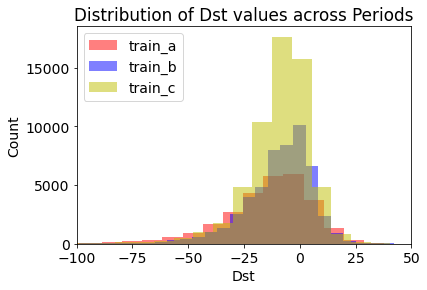

In [7]:
fig, ax = plt.subplots()
colors = ["r", "b", "y"]
for i, period in enumerate(dst.groupby("period")):
    period_name, df = period
    # FYI: For Google Colaborory (Python 3.7, Matplotlib 3.2.2), in the call to ax.hist(), you need to transpose the DataFrame.
    #      For Python 3.8+ (e.g. 3.9.7, with Matplotlib 3.5.1) it seems no tranpose is needed, thus this version switch.
    #      Below we differentiate on Python version, while you might want to differentiate on Matplotlib version.
    #      Error message you might see if DataFrame isn't oriented correctly: 
    #           "ValueError: color kwarg must have one color per data set. 28824 data sets and 1 colors were provided"
    import sys
    if float(sys.version[:3]) <= 3.7:
        ax.hist(df.T, alpha=0.5, color=colors[i], bins=50, label=period_name)
    else:
        ax.hist(df,   alpha=0.5, color=colors[i], bins=50, label=period_name)
    ax.set_xlim([-100,50])
    ax.set_xlabel('Dst')
    ax.set_ylabel('Count')

plt.legend()
plt.title("Distribution of Dst values across Periods")
plt.show()

### Solar Wind and Sunspots
This is our time series input (feature) data.

In [8]:
print("Solar wind shape: ", solar_wind.shape)
solar_wind.head(n=3)

Solar wind shape:  (8392320, 15)


bx_gse  by_gse  bz_gse  theta_gse  phi_gse  bx_gsm  \
period  timedelta                                                             
train_a 0 days 00:00:00   -5.55    3.00    1.25      11.09   153.37   -5.55   
        0 days 00:01:00   -5.58    3.16    1.17      10.10   151.91   -5.58   
        0 days 00:02:00   -5.15    3.66    0.85       7.87   146.04   -5.15   

                         by_gsm  bz_gsm  theta_gsm  phi_gsm    bt  density  \
period  timedelta                                                            
train_a 0 days 00:00:00    3.00    1.25      11.09   153.37  6.80     1.53   
        0 days 00:01:00    3.16    1.17      10.10   151.91  6.83     1.69   
        0 days 00:02:00    3.66    0.85       7.87   146.04  6.77     1.97   

                          speed  temperature source  
period  timedelta                                    
train_a 0 days 00:00:00  383.92     110237.0     ac  
        0 days 00:01:00  381.79     123825.0     ac  
        0 days 00:02:00  389.11      82548.0     ac

In [9]:
print("Sunspot shape: ", sunspots.shape)
sunspots.head(n=3)

Sunspot shape:  (192, 1)


smoothed_ssn
period  timedelta              
train_a 0 days             65.4
        13 days            72.0
        44 days            76.9

In [10]:
solar_wind.groupby("period").describe().T

period                  train_a       train_b       train_c
bx_gse      count  1.575012e+06  3.084130e+06  3.407290e+06
            mean  -1.781301e+00 -3.088789e-01 -4.619076e-01
            std    4.339212e+00  3.627830e+00  3.245485e+00
            min   -5.463000e+01 -2.937000e+01 -4.546000e+01
            25%   -4.960000e+00 -3.070000e+00 -2.800000e+00
...                         ...           ...           ...
temperature min    1.000000e+04  1.496000e+03  0.000000e+00
            25%    4.364900e+04  3.741400e+04  4.007400e+04
            50%    7.923800e+04  8.552400e+04  7.152100e+04
            75%    1.325500e+05  1.873250e+05  1.310880e+05
            max    6.223700e+06  4.206672e+06  5.751308e+06

[112 rows x 3 columns]

In [11]:
sunspots.groupby("period").describe().T

period                 train_a     train_b    train_c
smoothed_ssn count   40.000000   72.000000  80.000000
             mean   136.902500   51.850000  24.313750
             std     34.563168   39.200266  19.020414
             min     65.400000    3.900000   2.200000
             25%    108.375000   15.325000   7.775000
             50%    151.500000   43.150000  20.500000
             75%    164.400000   91.225000  38.525000
             max    175.200000  116.400000  69.500000

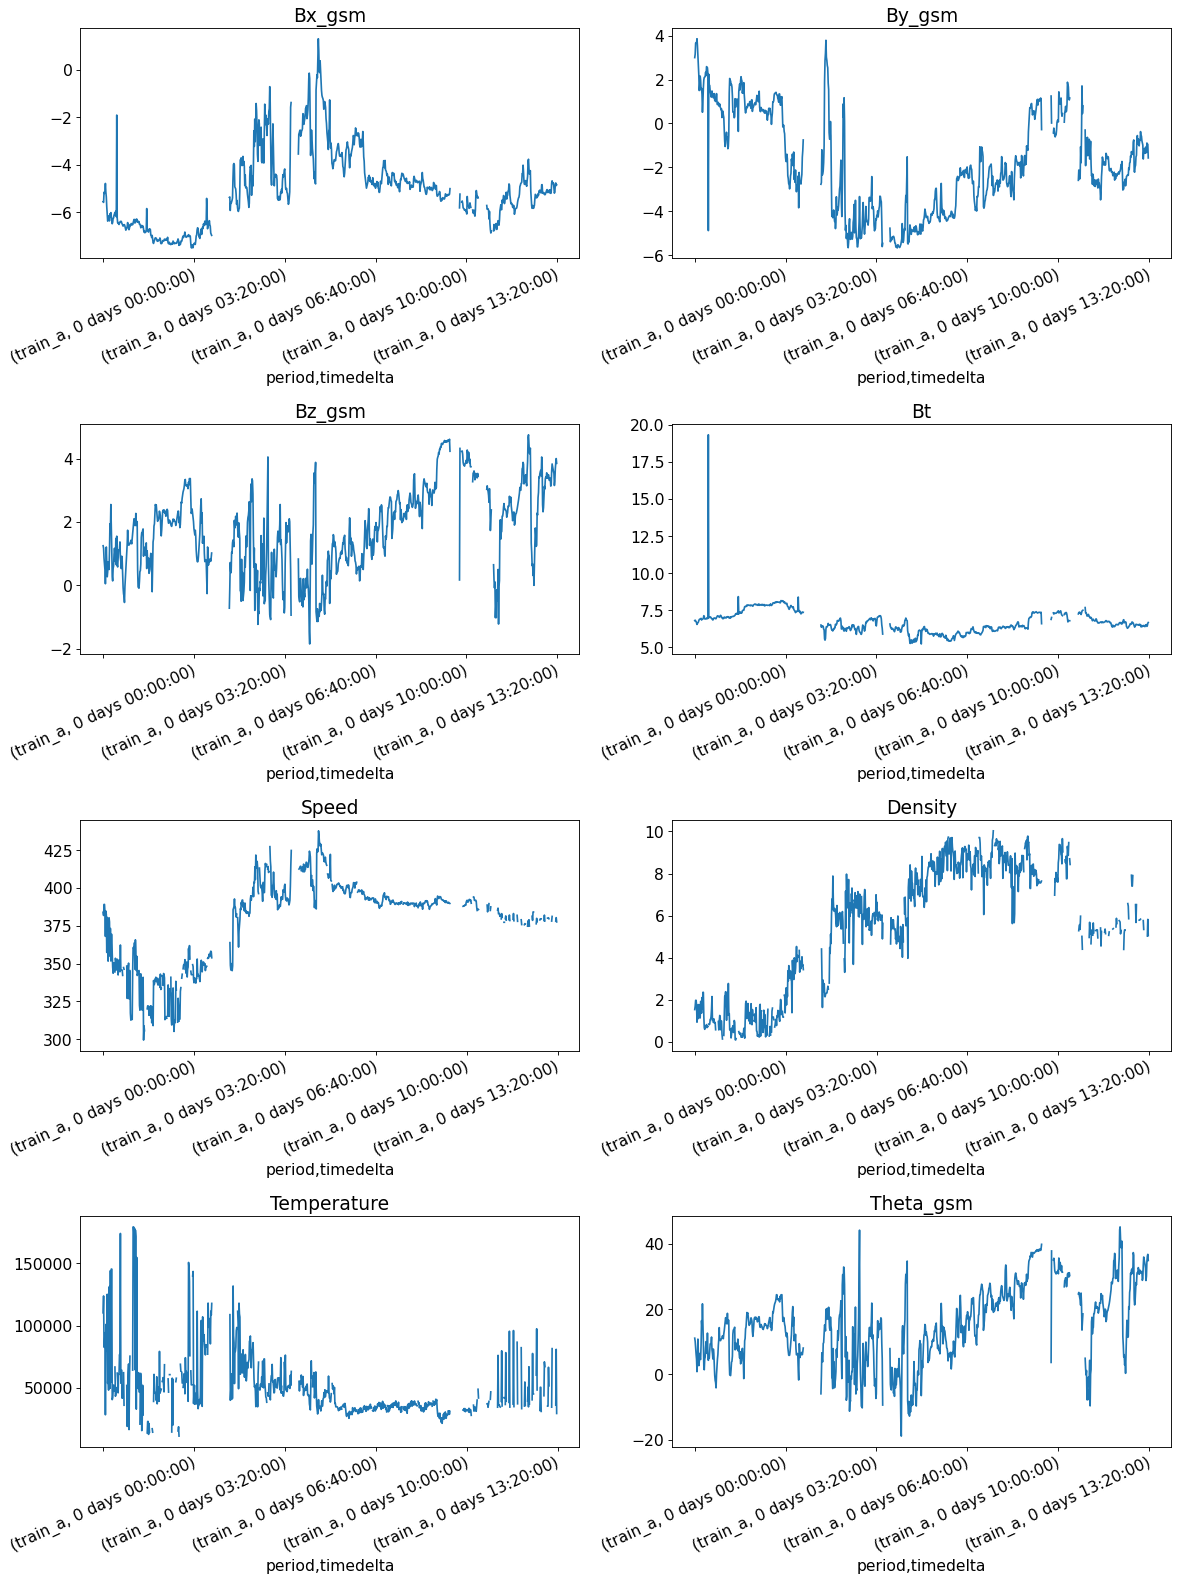

In [12]:
def show_raw_visualization(data):
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 20), dpi=80)
    for i, key in enumerate(data.columns):
        t_data = data[key]
        ax = t_data.plot(
            ax=axes[i // 2, i % 2],
            title=f"{key.capitalize()}",
            rot=25,
        )

    fig.subplots_adjust(hspace=0.8)
    plt.tight_layout()

cols_to_plot = ["bx_gsm", "by_gsm", "bz_gsm", "bt", "speed", "density", "temperature", "theta_gsm"]
show_raw_visualization(solar_wind[cols_to_plot].iloc[:1000])

### Data gaps in the Solar Wind data are a common issue with real-time data

<div class="alert alert-block alert-danger">
Gaps in our input (features) are something we'll need to deal carefully with, i.e. in the preprocessing steps below.
</div>

In [13]:
# What percent of the time are there gaps in these data?
print('Data gaps in solar input (features) as % of data:')
solar_wind.isna().sum()/len(solar_wind)*100

Data gaps in solar input (features) as % of data:


bx_gse         3.883169
by_gse         3.883169
bz_gse         3.883169
theta_gse      3.883169
phi_gse        3.889127
bx_gsm         3.883169
by_gsm         3.883169
bz_gsm         3.883169
theta_gsm      3.883169
phi_gsm        3.889127
bt             3.883169
density        8.160914
speed          8.216500
temperature    9.672748
source         3.775071
dtype: float64

<div class="alert alert-block alert-info">
<b>Question: </b>What challenges in working with these "operational" observations of the solar wind will we need to solve before modeling? What complexities of the data will need to be captured and solved by the model?
</div>

<div class="alert alert-block alert-info">
<i>You can use this empty cell to write down your thoughts regarding the preceding question(s).</i>
</div>

## Feature Relationships

In [14]:
# Correlation matrix:
#     Note that this is a slow command (several minutes) unless you have a GPU or TPU equivalent processor (then it's ~1 min).
#     Take advantage of Pandas DataFrame and merge our Input (Feature) and Output (Label) data.
#     I.e. merge, Solar Wind + Sunspots + Satellite Location + Dst
corr = solar_wind.join(sunspots).join(satellite_positions).join(dst).fillna(method="ffill").corr()

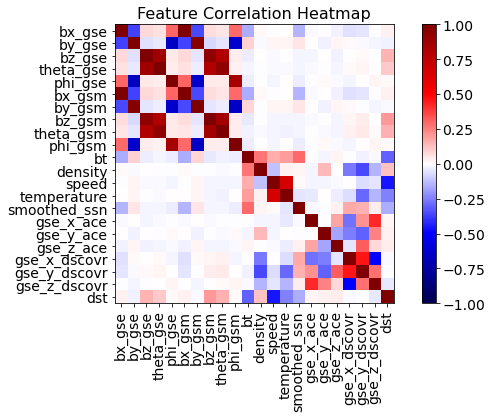

In [15]:
plt.figure(figsize=(10, 5))
plt.matshow(corr, cmap='seismic', vmin=-1, vmax=1, fignum=1)
plt.xticks(range(corr.shape[1]), corr.columns, rotation=90)
plt.gca().xaxis.tick_bottom()
plt.yticks(range(corr.shape[1]), corr.columns)


cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

<div class="alert alert-block alert-info">
<b>Question: </b>Evaluate the feature correlation heatmap figure. What input (features) are correlated with each other and which ones are correlated with our output <i>Dst</i>? Does satellite location seem to be important or not? You might like to consult the input parameter descriptions in the "Data Notes" section near the top of this notebook.
</div>

<div class="alert alert-block alert-info">
<i>You can use this empty cell to write down your thoughts regarding the preceding question(s).</i>
</div>

# Feature Generation

## Set seeds for reproducibility

In [16]:
from numpy.random import seed
from tensorflow.random import set_seed

seed(2020)
set_seed(2021)

## Feature / Input Data we'll use to Train the Model

<div class="alert alert-block alert-warning">
<b>Optional Task: </b> What features would you recommend for use in developing our model? What additional considerations should we evaluate before using our chosen features to develop a model? Are there any additional features we should look at that are not in our list? 
</div>

<div class="alert alert-block alert-warning">
<b>Optional Task: </b> Use a different list of features and evaluate the trade offs and your model's performance.
</div>

In [17]:
# subset of solar wind features to use for modeling
SOLAR_WIND_FEATURES = [
    "bt",
    "temperature",
    "bx_gsm",
    "by_gsm",
    "bz_gsm",
    "speed",
    "density",
]

In [18]:
# The model will be built on feature statistics, mean and standard deviation
XCOLS = (
    [col + "_mean" for col in SOLAR_WIND_FEATURES]
    + [col + "_std" for col in SOLAR_WIND_FEATURES]
    + ["smoothed_ssn"]
)

<div class="alert alert-block alert-success">
<b>Preparing Inputs (Features): </b>As discussed above, we'll need to fill in gaps and create statistical summaries (hourly means and standard deviations) of our features before modeling. The following routines provide this "preprocessing" functionality of gap filling, and scaling by features' statistics.
</div>

<div class="alert alert-block alert-warning">
<b>Optional Task: </b> In this LSTM notebook, we use means and standard deviations. Consider and perhaps try different statistical tools such as medians and inner quartile ranges, such as used in our sibling CNN notebook.
</div>

In [19]:
from sklearn.preprocessing import StandardScaler

def impute_features(feature_df):
    """Imputes data using the following methods:
    - `smoothed_ssn`: forward fill
    - `solar_wind`: interpolation
    """
    # forward fill sunspot data for the rest of the month
    feature_df.smoothed_ssn = feature_df.smoothed_ssn.fillna(method="ffill")
    # interpolate between missing solar wind values
    feature_df = feature_df.interpolate()
    return feature_df


def aggregate_hourly(feature_df, aggs=["mean", "std"]):
    """Aggregates features to the floor of each hour using mean and standard deviation.
    e.g. All values from "11:00:00" to "11:59:00" will be aggregated to "11:00:00".
    """
    # group by the floor of each hour use timedelta index
    agged = feature_df.groupby(
        ["period", feature_df.index.get_level_values(1).floor("H")]
    ).agg(aggs)
    # flatten hierachical column index
    agged.columns = ["_".join(x) for x in agged.columns]
    return agged


def preprocess_features(solar_wind, sunspots, scaler=None, subset=None):
    """
    Preprocessing steps:
        - Subset the data
        - Aggregate hourly
        - Join solar wind and sunspot data
        - Scale using standard scaler
        - Impute missing values
    """
    # select features we want to use
    if subset:
        solar_wind = solar_wind[subset]

    # aggregate solar wind data and join with sunspots
    hourly_features = aggregate_hourly(solar_wind).join(sunspots)

    # subtract mean and divide by standard deviation
    if scaler is None:
        scaler = StandardScaler()
        scaler.fit(hourly_features)

    normalized = pd.DataFrame(
        scaler.transform(hourly_features),
        index=hourly_features.index,
        columns=hourly_features.columns,
    )

    # impute missing values
    imputed = impute_features(normalized)

    # we want to return the scaler object as well to use later during prediction
    return imputed, scaler

In [20]:
features, scaler = preprocess_features(solar_wind, sunspots, subset=SOLAR_WIND_FEATURES)
print(features.shape)
features.head(n=3)

(139872, 15)


bt_mean    bt_std  temperature_mean  \
period  timedelta                                               
train_a 0 days 00:00:00  0.499705  2.443614         -0.375267   
        0 days 01:00:00  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  0.739905 -0.770240         -0.574831   

                         temperature_std  bx_gsm_mean  bx_gsm_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.600307   -0.381727   
        0 days 01:00:00         0.953178    -1.759200   -0.868044   
        0 days 02:00:00        -0.192518    -1.913422   -1.114649   

                         by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.434424    0.021156     0.292754   -0.645095   
        0 days 01:00:00     0.189021   -0.282845     0.433737   -0.511040   
        0 days 02:00:00     0.193116   -0.831526     0.747220   -0.870482   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444

In [21]:
# check to make sure missing values are filled
assert (features.isna().sum() == 0).all()

<div class="alert alert-block alert-success">
<b>Preparing <i>Dst</i>: </b>We also need to prepare our output (labels), i.e. our space weather storm index <i>Dst</i>, which is already a time series with an hourly cadence. The modelling task is to predict <i>Dst</i> at hour t0 and the next hour t1.
</div>

In [22]:
YCOLS = ["t0", "t1"]


def process_labels(dst):
    y = dst.copy()
    y["t0"] = y.groupby("period").dst.shift(-1)
    y["t1"] = y.groupby("period").dst.shift(-2)
    return y[YCOLS]


labels = process_labels(dst)
labels.head(n=3)

t0    t1
period  timedelta                  
train_a 0 days 00:00:00 -10.0 -10.0
        0 days 01:00:00 -10.0  -6.0
        0 days 02:00:00  -6.0  -2.0

<div class="alert alert-block alert-success">
<b>Features + Labels </b>: For convenience, join our processed solar wind hourly inputs and our <i>Dst</i> labels into one DataFrame.
</div>

In [23]:
data = labels.join(features)
data.head(n=3)

t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00 -10.0 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10.0  -6.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  -6.0  -2.0  0.739905 -0.770240         -0.574831   

                         temperature_std  bx_gsm_mean  bx_gsm_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.600307   -0.381727   
        0 days 01:00:00         0.953178    -1.759200   -0.868044   
        0 days 02:00:00        -0.192518    -1.913422   -1.114649   

                         by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.434424    0.021156     0.292754   -0.645095   
        0 days 01:00:00     0.189021   -0.282845     0.433737   -0.511040   
        0 days 02:00:00     0.193116   -0.831526     0.747220   -0.870482   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444

# Splitting the Data

<div class="alert alert-block alert-success">
We'll split our features and labels into Training, Testing and Validation sets for each of the 3 training periods, named train_a, train_b, train_c (see Data Notes for additional details).
</div>

In [24]:
def get_train_test_val(data, test_per_period, val_per_period):
    """Splits data across periods into train, test, and validation"""
    # assign the last `test_per_period` rows from each period to test
    test = data.groupby("period").tail(test_per_period)
    interim = data[~data.index.isin(test.index)]
    # assign the last `val_per_period` from the remaining rows to validation
    val = interim.groupby("period").tail(val_per_period)
    # the remaining rows are assigned to train
    train = interim[~interim.index.isin(val.index)]
    return train, test, val


train, test, val = get_train_test_val(data, test_per_period=6_000, val_per_period=3_000)

## Visualize splits - Counts across periods

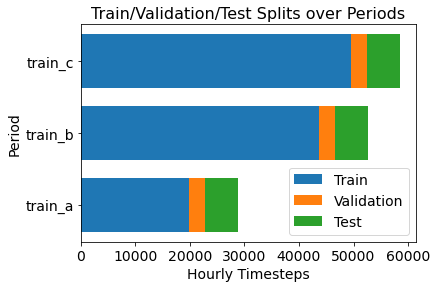

In [25]:
ind = [0, 1, 2]
names = ["train_a", "train_b", "train_c"]
width = 0.75
train_cnts = [len(df) for _, df in train.groupby("period")]
val_cnts = [len(df) for _, df in val.groupby("period")]
test_cnts = [len(df) for _, df in test.groupby("period")]

p1 = plt.barh(ind, train_cnts, width)
p2 = plt.barh(ind, val_cnts, width, left=train_cnts)
p3 = plt.barh(ind, test_cnts, width, left=np.add(val_cnts, train_cnts).tolist())

plt.yticks(ind, names)
plt.ylabel("Period")
plt.xlabel("Hourly Timesteps")
plt.title("Train/Validation/Test Splits over Periods", fontsize=16)
plt.legend(["Train", "Validation", "Test"])

## Final look at each of our "Training", "Test", and "Validation" datasets

In [26]:
print(train.shape)
train.head(n=3)

(112872, 17)


t0    t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 0 days 00:00:00 -10.0 -10.0  0.499705  2.443614         -0.375267   
        0 days 01:00:00 -10.0  -6.0  0.547177 -0.224580         -0.479430   
        0 days 02:00:00  -6.0  -2.0  0.739905 -0.770240         -0.574831   

                         temperature_std  bx_gsm_mean  bx_gsm_std  \
period  timedelta                                                   
train_a 0 days 00:00:00         0.383941    -1.600307   -0.381727   
        0 days 01:00:00         0.953178    -1.759200   -0.868044   
        0 days 02:00:00        -0.192518    -1.913422   -1.114649   

                         by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period  timedelta                                                           
train_a 0 days 00:00:00     0.434424    0.021156     0.292754   -0.645095   
        0 days 01:00:00     0.189021   -0.282845     0.433737   -0.511040   
        0 days 02:00:00     0.193116   -0.831526     0.747220   -0.870482   

                         speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                           
train_a 0 days 00:00:00   -0.738546   0.862524     -0.775827    -0.205724   
        0 days 01:00:00   -0.986904   0.995063     -0.861692    -0.058215   
        0 days 02:00:00   -1.013548   0.554085     -0.846222    -0.220012   

                         smoothed_ssn  
period  timedelta                      
train_a 0 days 00:00:00      0.139444  
        0 days 01:00:00      0.139444  
        0 days 02:00:00      0.139444

In [27]:
print(test.shape)
test.head(n=3)

(18000, 17)


t0   t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 951 days 00:00:00 -9.0 -9.0 -0.750759  0.234958         -0.321374   
        951 days 01:00:00 -9.0 -6.0 -0.791318  0.284752         -0.319784   
        951 days 02:00:00 -6.0 -7.0 -0.980331  0.573975         -0.257948   

                           temperature_std  bx_gsm_mean  bx_gsm_std  \
period  timedelta                                                     
train_a 951 days 00:00:00        -0.263304     0.437725   -0.443382   
        951 days 01:00:00        -0.301259     0.321538    0.422262   
        951 days 02:00:00        -0.344924     0.531028    0.818507   

                           by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period  timedelta                                                             
train_a 951 days 00:00:00    -0.029034    0.535552     0.847807   -0.303401   
        951 days 01:00:00    -0.064711    0.149080     0.799132   -0.226211   
        951 days 02:00:00    -0.095468    0.329294     0.176357   -0.555706   

                           speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                             
train_a 951 days 00:00:00   -0.145924  -0.503193     -0.407614    -0.315154   
        951 days 01:00:00   -0.127991  -0.084971     -0.427620    -0.198320   
        951 days 02:00:00   -0.120626  -0.310757     -0.435274    -0.374498   

                           smoothed_ssn  
period  timedelta                        
train_a 951 days 00:00:00      2.113449  
        951 days 01:00:00      2.113449  
        951 days 02:00:00      2.113449

In [28]:
print(val.shape)
val.head(n=3)

(9000, 17)


t0   t1   bt_mean    bt_std  temperature_mean  \
period  timedelta                                                           
train_a 826 days 00:00:00  8.0  8.0  0.947600 -0.229038         -0.473006   
        826 days 01:00:00  8.0  9.0  0.464361  0.276422          0.316358   
        826 days 02:00:00  9.0  8.0  0.273709  0.197794          0.073052   

                           temperature_std  bx_gsm_mean  bx_gsm_std  \
period  timedelta                                                     
train_a 826 days 00:00:00        -0.372466    -1.576857   -0.883102   
        826 days 01:00:00         0.379133    -1.615778   -0.280737   
        826 days 02:00:00         0.302776    -1.130926    0.809599   

                           by_gsm_mean  by_gsm_std  bz_gsm_mean  bz_gsm_std  \
period  timedelta                                                             
train_a 826 days 00:00:00    -0.452683    1.126953     1.736395   -0.218641   
        826 days 01:00:00     0.240716    0.600711     0.668598    0.280798   
        826 days 02:00:00     0.634785    0.022706    -1.065113   -0.260871   

                           speed_mean  speed_std  density_mean  density_std  \
period  timedelta                                                             
train_a 826 days 00:00:00   -0.323757  -0.527592      0.392352    -0.296261   
        826 days 01:00:00   -0.155733   0.142157      0.022523    -0.150077   
        826 days 02:00:00   -0.072557   0.563556     -0.200011    -0.089490   

                           smoothed_ssn  
period  timedelta                        
train_a 826 days 00:00:00      2.191722  
        826 days 01:00:00      2.191722  
        826 days 02:00:00      2.191722

# Load a Pre-Trained Model - <i>Optional</i>

<div class="alert alert-block alert-warning">
<b>Optional Task: </b>You can use the following cells to load a pre-trained model, or you can skip ahead and train a new model yourself.
</div>

In [29]:
create_new_model = True     # Set True to skip next section and create a new model.
                            # Set False to load a pre-trained model.

## If Pre-existing then load Model, Scaler, History and Configuration

In [30]:
import tensorflow.keras as keras

import glob
# List existing LSTM models:
dir_list = glob.glob('trained_models_lstm/model_lstm_*/')
print('Here is a list of pre-trained models:\n')
for i in range(len(dir_list)):
    print('    %d: %s' % (i, dir_list[i]))

if not create_new_model:
    dir_model = dir_list[int(input('Enter number of pre-trained model: '))]
    
    import json
    import pickle
    
    # Load in serialized model, config, and scaler
    print('Loading pre-trained model from: %s' % dir_model)
    model = keras.models.load_model(dir_model)
    model.summary()

    # Load Scaler
    with open(dir_model+"/scaler.pck", "rb") as f:
        scaler = pickle.load(f)
    print('Scaler:')
    pprint.pprint(scaler)

    # Load History
    with open(dir_model+"/history.pck", "rb") as f:
        history = pickle.load(f)
    print('History:')
    pprint.pprint(history)

    # Load Configuration
    with open(dir_model+"/config.json", "r") as f:
        data_config = json.load(f)
    print('Configuration:')
    pprint.pprint(data_config)


Here is a list of pre-trained models:

    0: trained_models_lstm/model_lstm_nepochs-04_nneurons-0016/
    1: trained_models_lstm/model_lstm_nepochs-30_nneurons-2048/
    2: trained_models_lstm/model_lstm_nepochs-20_nneurons-0512/
    3: trained_models_lstm/model_lstm_nepochs-08_nneurons-0064/


# Define and Build our LSTM Model

## Define LSTM Model

<div class="alert alert-block alert-warning">
<b>Optional Task (highly recommended): </b>The initial LSTM hyper parameters are set for speed. Load a pre-trained model or adjust these yourself and evaluate consequences on model convergence and storm event use case performance.
</div>

In [31]:
# If we're Defining and Training a New Model
if create_new_model:
    from keras.layers import Dense, LSTM
    from keras.models import Sequential

    # Define our model
    data_config = {
        "timesteps": 32,
        "batch_size": 32,
    }
    print('data_config = ')
    pprint.pprint(data_config)

    # Hyper Parameter Tuning
    #
    # Going Big (takes hours):
    #      model_config = {"n_epochs": 30, "n_neurons": 2048, "dropout": 0.4, "stateful": False}
    #
    # Original from MagNet blogpost benchmark, takes about 1.5 hours:
    #      model_config = {"n_epochs": 20, "n_neurons": 512, "dropout": 0.4, "stateful": False}
    #
    # Takes 10-15 minutes (moderate performance): 
    #      model_config = {"n_epochs": 8, "n_neurons": 64, "dropout": 0.4, "stateful": False}
    #
    # Takes 20 seconds (anticipate bad performance):
    model_config = {"n_epochs": 4, "n_neurons": 16, "dropout": 0.4, "stateful": False}

    model = Sequential()
    model.add(
        LSTM(
            model_config["n_neurons"],
            # usually set to (`batch_size`, `sequence_length`, `n_features`)
            # setting the batch size to None allows for variable length batches
            batch_input_shape=(None, data_config["timesteps"], len(XCOLS)),
            stateful=model_config["stateful"],
            dropout=model_config["dropout"],
        )
    )
    model.add(Dense(len(YCOLS)))
    model.compile(
        loss="mean_squared_error",
        optimizer="adam",
        run_eagerly=None,     # set to True for debugging (very slow), None or False
    )

    model.summary()


data_config = 
{'batch_size': 32, 'timesteps': 32}


2022-06-21 15:21:10.511916: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16)                2048      
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
Total params: 2,082
Trainable params: 2,082
Non-trainable params: 0
_________________________________________________________________


## Train Model

### BatchDataset: Training, Validation and Test Data
In order to train and/or test our New or Pre-trained model, we'll create <i>[tensorflow.python.data.ops.dataset_ops.BatchDataset](https://www.tensorflow.org/guide/data#batching_dataset_elements)</i> structures for our Training, Validation and Test DataFrames.

In [32]:
import tensorflow.keras as keras
from keras import preprocessing

def timeseries_dataset_from_df(df, batch_size):
    dataset = None
    timesteps = data_config["timesteps"]

    # iterate through periods
    for _, period_df in df.groupby("period"):
        # realign features and labels so that first sequence of 32 is aligned with the 33rd target
        inputs = period_df[XCOLS][:-timesteps]
        outputs = period_df[YCOLS][timesteps:]

        period_ds = keras.preprocessing.timeseries_dataset_from_array(
            inputs,
            outputs,
            timesteps,
            batch_size=batch_size,
        )

        if dataset is None:
            dataset = period_ds
        else:
            dataset = dataset.concatenate(period_ds)
        
    return dataset



In [33]:
train_ds = timeseries_dataset_from_df(train, data_config["batch_size"])
val_ds   = timeseries_dataset_from_df(val,   data_config["batch_size"])
test_ds  = timeseries_dataset_from_df(test,  data_config["batch_size"])

print(f"Number of training batches: {len(train_ds)}")
print(f"Number of validation batches: {len(val_ds)}")
print(f"Number of test batches: {len(test_ds)}")

Number of training batches: 3523
Number of validation batches: 276
Number of test batches: 558


<div class="alert alert-block alert-success">
<b>Take a break: </b>Depending on the settings you chose above, you might go grab a snack or a cup of coffee/tea. If your model is likely to take several hours to train, perhaps open another copy of this notebook so you can work in parallel.
</div>

In [34]:
# If we're training a New model:
if create_new_model:
    history = model.fit(
        train_ds,
        batch_size=data_config["batch_size"],
        epochs=model_config["n_epochs"],
        verbose=True,
        shuffle=False,
        validation_data=val_ds,
    )

Epoch 1/4
3523/3523 [==============================] - 32s 9ms/step - loss: 306.4037 - val_loss: 412.8713
Epoch 2/4
3523/3523 [==============================] - 31s 9ms/step - loss: 215.6080 - val_loss: 366.2506
Epoch 3/4
3523/3523 [==============================] - 29s 8ms/step - loss: 192.2224 - val_loss: 341.4531
Epoch 4/4
3523/3523 [==============================] - 29s 8ms/step - loss: 178.4406 - val_loss: 325.9473


## Evaluate Trained Model

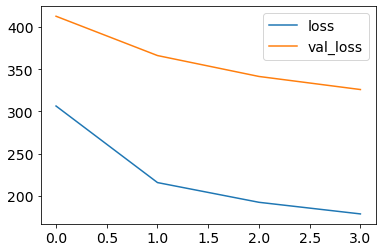

In [35]:
for name, values in history.history.items():
    plt.plot(values, label=name)
plt.legend(fontsize=14)
plt.show()

In [36]:
rmse = model.evaluate(test_ds)**0.5
print(f"Test RMSE: {rmse:.2f} nano-Tesla")

558/558 [==============================] - 2s 3ms/step - loss: 272.5471
Test RMSE: 16.51 nano-Tesla


<div class="alert alert-block alert-info">
<b>Question: </b>Did the model converge, ie. how flat are the loss curves above? What hyper parameters might you tune?
</div>

<div class="alert alert-block alert-info">
<i>You can use this empty cell to write down your thoughts regarding the preceding question(s).</i>
</div>

# Save and Load the Model

<div class="alert alert-block alert-success">
<b>Model and Scaler: </b>Recall that we used a scaler (mean and standard deviation) to scale the features. We'll need to save both the trained model and scaler if we'd like to use it again in a future Jupyter session without having to retrain.
</div>

## Save: New Model, Scaler, History and Configuration

In [37]:
if create_new_model:
    # Pickle the Scaler and History, and JSON the Config
    import json
    import pickle

    # Keep our models in their own subdirectories
    dir_model = 'trained_models_lstm/model_lstm_nepochs-%02d_nneurons-%04d/' % \
        (model_config['n_epochs'], model_config['n_neurons'])

    # Save Model
    model.save(dir_model)

    # Save Scaler (pickle)
    with open(dir_model+"/scaler.pck", "wb") as f:
        pickle.dump(scaler, f)

    # Save History (pickle)
    with open(dir_model+"/history.pck", "wb") as f:
        pickle.dump(history, f)

    # Save Configuration (as JSON)
    data_config["solar_wind_subset"] = SOLAR_WIND_FEATURES
    with open(dir_model+"/config.json", "w") as f:
        json.dump(data_config, f)

    print('Saved model to %s' % dir_model)

2022-06-21 15:23:15.357202: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: trained_models_lstm/model_lstm_nepochs-04_nneurons-0016/assets


INFO:tensorflow:Assets written to: trained_models_lstm/model_lstm_nepochs-04_nneurons-0016/assets


INFO:tensorflow:Assets written to: ram://d65b17e8-336b-4bfe-8293-7f38c23ef3e8/assets


INFO:tensorflow:Assets written to: ram://d65b17e8-336b-4bfe-8293-7f38c23ef3e8/assets


Saved model to trained_models_lstm/model_lstm_nepochs-04_nneurons-0016/


# Explainable AI (XAI)

## Permutation Importance - Easy Approximation

<div class="alert alert-block alert-success">
Based on Christoph Molnar's "Interpretable Machine Learning" section and Fisher, Rudin, and Dominici (2018), we will "split the dataset in half and swap the values of feature j of the two halves instead of permuting feature j".     
</div>

Resources:
*   Christoph Molnar's "Interpretable Machine Learning" section on [Permutation Feature Importance](https://christophm.github.io/interpretable-ml-book/feature-importance.html), and see also their <b>argument for using Test data</b> for Permutation Importance evaluation, which we have chosen to do here.
*   [See this illustrative graphic demonstrating single- and multi-pass Permutation Importance](https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance)
*   [Permutation Feature Importance in the <i>scikit-learn</i> module](https://scikit-learn.org/stable/modules/permutation_importance.html)


Basically, we can split and swap the feature datasets one feature at a time and compare the resultant RMSE. We take a programming convenience shortcut and <b>simply reverse each feature</b> vector rather than split and swap and we expect the same results. We'll do this, i.e. permute each feature vector, one at a time.

Recall that our <i>test_ds</i> which we used to evaluate the model performance is a [tensorflow.python.data.ops.dataset_ops.BatchDataset](https://www.tensorflow.org/guide/data#batching_dataset_elements) and these are honestly kind of hard to work with. So we will recreate a deep copy of <i>test_ds</i> for each permutation and so we don't corrupt the original.

In [38]:
# Note: We shouldn't need these two lines below but they seem needed generalizing to run w/o
#       issues on both Colaboratory (Python 3.7) and Jupyter server with Python 3.9.
#       Contact POCs if you get an error such as:
#            AttributeError: module 'keras.preprocessing' has no attribute 'timeseries_dataset_from_array'
import tensorflow.keras as keras
from keras import preprocessing

In [39]:
# A couple of ways to learn about the contents of a BatchDataset:
#   print(list(train_ds.as_numpy_iterator()))
#   type(test_ds)


rmse_permute_df = pd.DataFrame(np.zeros((1,len(XCOLS))), columns=XCOLS)
for fname in XCOLS:

    # We're going to edit this data so make a deep copy of our preprocessed training dataset.
    test_for_permute = test.copy(deep=True) 
    
    # Approximate split permutation by simply reversing the data in this feature
    test_for_permute[fname].values[:] = test_for_permute[fname].values[::-1]

    # create TensorFlow BatchDataset
    permute_ds = timeseries_dataset_from_df(test_for_permute, data_config["batch_size"])

    # evaluate model
    rmse_permute_df[fname] = model.evaluate(permute_ds)**0.5

    print('%s: %f rmse nano-Tesla' % (fname, rmse_permute_df[fname]))

558/558 [==============================] - 2s 3ms/step - loss: 287.7553
bt_mean: 16.963351 rmse nano-Tesla
558/558 [==============================] - 2s 3ms/step - loss: 272.7914
temperature_mean: 16.516398 rmse nano-Tesla
558/558 [==============================] - 2s 3ms/step - loss: 276.6721
bx_gsm_mean: 16.633463 rmse nano-Tesla
558/558 [==============================] - 2s 3ms/step - loss: 275.3690
by_gsm_mean: 16.594245 rmse nano-Tesla
558/558 [==============================] - 2s 3ms/step - loss: 391.8803
bz_gsm_mean: 19.795968 rmse nano-Tesla
558/558 [==============================] - 2s 3ms/step - loss: 324.0503
speed_mean: 18.001398 rmse nano-Tesla
558/558 [==============================] - 2s 3ms/step - loss: 272.8078
density_mean: 16.516893 rmse nano-Tesla
558/558 [==============================] - 2s 3ms/step - loss: 274.6892
bt_std: 16.573751 rmse nano-Tesla
558/558 [==============================] - 2s 3ms/step - loss: 272.3380
temperature_std: 16.502665 rmse nano-Tesla
5

<div class="alert alert-block alert-success">
<b>Relative Comparison: </b>Permutation Importance is evaluated as the influence a feature has  relative to our unpermuted baseline performance. It's typical to use either a ratio or subtraction to relate to our baseline.
</div>

In [40]:
# Ratio the Permuted RMSE to the overall RMSE and sort in order of importance
print('In order of most important feature first to least important by rmse(j)/rmse:')
rmse_ratio_df = (rmse_permute_df/rmse).sort_values(ascending=False, by=0, axis=1)
rmse_ratio_df.T

In order of most important feature first to least important by rmse(j)/rmse:


,0
bz_gsm_mean,1.199102
speed_mean,1.090399
bt_mean,1.027521
smoothed_ssn,1.014216
bx_gsm_mean,1.007539
by_gsm_mean,1.005164
bt_std,1.003922
speed_std,1.002348
bz_gsm_std,1.002227
density_mean,1.000478


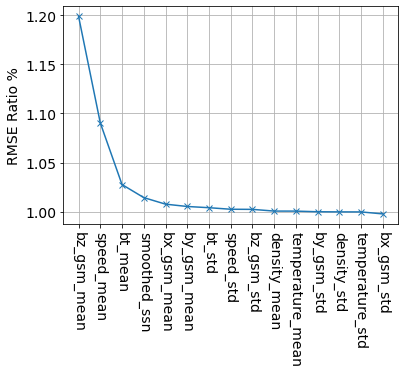

In [41]:
# Visualize the Permutation Importance outcome
plt.plot(rmse_ratio_df.columns, rmse_ratio_df.values.T, 'x-')
plt.xticks(rotation=270)
plt.ylabel('RMSE Ratio %')
plt.grid(True)
plt.show()

# Uncomment for a Pandas barplot with too many colors to easily interpret:
#rmse_ratio_df.plot(kind='bar', figsize=(10, 5))
#plt.title('Permutation Feature Importance')
#plt.xlim(-0.25,)
#plt.ylim(0.95, rmse_ratio_df.iloc[0,0])
#plt.grid(True)
#plt.tight_layout()

### Review the feature Permutation Importances

<div class="alert alert-block alert-info">
<b>Questions: </b>

- How do our features compare in their influence on performance? 
    
- How does the order of this list compare to your intuition from the Feature Correlation Heatmap we made earlier (aka heat map)?
    
- What are the model sensitivities to the input parameters? If one or more solar wind instruments were to degrade on orbit how do you predict that might impact model performance? 
</div>

<div class="alert alert-block alert-info">
<i>You can use this empty cell to write down your thoughts regarding the preceding question(s).</i>
</div>

## Student Exercise: SHapley Additive exPlanations (SHAP)

Use the SHapley Additive exPlanations (SHAP) by Lundberg and Lee (2017) methodology to explore the contribution of each feature on the predicted output labels for a specific event.

Resources you might like to explore:
*   [Interpreting your deep learning model by SHAP](https://towardsdatascience.com/interpreting-your-deep-learning-model-by-shap-e69be2b47893)
*   [Interpretable Machine Learning by Christop Molnar](https://christophm.github.io/interpretable-ml-book/shap.html)
*   [Keras LSTM for IMDB Sentiment Classification](https://shap.readthedocs.io/en/latest/example_notebooks/text_examples/sentiment_analysis/Keras%20LSTM%20for%20IMDB%20Sentiment%20Classification.html?highlight=LSTM)

<div class="alert alert-block alert-warning">
<b>Optional Task: SHapley Additive exPlanations (SHAP)</b>
    
Use the SHapley Additive exPlanations (SHAP) by Lundberg and Lee (2017) methodology to explore the contribution of each feature on the predicted output labels for a specific event.

Resources you might like to explore:

- Interpreting your deep learning model by SHAP
- Interpretable Machine Learning by Christop Molnar
- Keras LSTM for IMDB Sentiment Classification    
    
</div>

## Note on SKT-Explain

<div class="alert alert-block alert-success">

While the current version of [skt-explain](https://github.com/monte-flora/scikit-explain) module isn't compatible with our tabular LSTM model (and sister CNN notebook), you might like to monitor this module's progress for your various needs--they have some really wonderful XAI tools and visualizations.

</div>

# Event Case Studies

## Define Prediction Function

In [42]:
from typing import Tuple

TIMESTEPS = data_config['timesteps']

def predict_dst(
    solar_wind_7d: pd.DataFrame,
    satellite_positions_7d: pd.DataFrame,
    latest_sunspot_number: float,
) -> Tuple[float, float]:
    """
    Take all of the data up until time t-1, and then make predictions for
    times t and t+1.
    Parameters
    ----------
    solar_wind_7d: pd.DataFrame
        The last 7 days of satellite data up until (t - 1) minutes [exclusive of t]
    satellite_positions_7d: pd.DataFrame
        The last 7 days of satellite position data up until the present time [inclusive of t]
    latest_sunspot_number: float
        The latest monthly sunspot number (SSN) to be available
    Returns
    -------
    predictions : Tuple[float, float]
        A tuple of two predictions, for (t and t + 1 hour) respectively; these should
        be between -2,000 and 500.
    """
    # Re-format data to fit into our pipeline
    sunspots = pd.DataFrame(index=solar_wind_7d.index, columns=["smoothed_ssn"])
    sunspots["smoothed_ssn"].values[:] = latest_sunspot_number
    
    # Process our features and grab last 32 (timesteps) hours
    features, s = preprocess_features(
        solar_wind_7d, sunspots, scaler=scaler, subset=SOLAR_WIND_FEATURES
    )
    model_input = features[-TIMESTEPS:][XCOLS].values.reshape(
        (1, TIMESTEPS, features.shape[1])
    )
    #pprint.pprint(features)
    
    # Make a prediction
    prediction_at_t0, prediction_at_t1 = model.predict(model_input)[0]

    # Optional check for unexpected values
    if not np.isfinite(prediction_at_t0):
        prediction_at_t0 = -12
    if not np.isfinite(prediction_at_t1):
        prediction_at_t1 = -12

    return prediction_at_t0, prediction_at_t1

## Ingest Real Event Data from Competition's "Private" Data

In [43]:
# Real Event Data from PRIVATE
DATA_PATH = Path("data/private/")
print('Importing data from: %s' % DATA_PATH)

dst = pd.read_csv(DATA_PATH / "dst_labels.csv")
dst.timedelta = pd.to_timedelta(dst.timedelta)
dst.set_index(["period", "timedelta"], inplace=True)

sunspots = pd.read_csv(DATA_PATH / "sunspots.csv")
sunspots.timedelta = pd.to_timedelta(sunspots.timedelta)
sunspots.set_index(["period", "timedelta"], inplace=True)

solar_wind = pd.read_csv(DATA_PATH / "solar_wind.csv")
solar_wind.timedelta = pd.to_timedelta(solar_wind.timedelta)
solar_wind.set_index(["period", "timedelta"], inplace=True)

satellite_positions = pd.read_csv(DATA_PATH / "satellite_positions.csv")
satellite_positions.timedelta = pd.to_timedelta(satellite_positions.timedelta)
satellite_positions.set_index(["period", "timedelta"], inplace=True)

Importing data from: data/private


## Event: Geomagnetic storm with <i>Dst</i> minimum of approx. -180 nT

<div class="alert alert-block alert-info">
<b>Questions: </b>

- How does our LSTM model output for this event look compared to our observed <i>Dst</i>?
- How does our LSTM model performance compare to the CNN notebook for this event?
</div>

<div class="alert alert-block alert-info">
<i>You can use this empty cell to write down your thoughts regarding the preceding question(s).</i>
</div>

In [44]:
# Here we've chosen a specific event case study, you can choose different 
#      case studied by looking at the sibling notebook magnet_cnn_tutorial.ipynb
event_start_day = 140
idx_event_1day = range(event_start_day,       event_start_day       + 7      )
idx_event_1hr  = range(event_start_day*24,    event_start_day*24    + 7*24   )
idx_event_1min = range(event_start_day*24*60, event_start_day*24*60 + 7*24*60)

dst_predicted_t0 = np.nan * np.zeros(len(idx_event_1hr))
dst_predicted_t1 = np.nan * np.zeros(len(idx_event_1hr))
i_dst = 0
###idx_1min = range((event_start_day-7)*24*60, event_start_day*24*60)
for i_offset_hour in range(-7*24, 0):
    
    # for the 
    idx_7day_1min = range(idx_event_1min[0]+i_offset_hour*60 - 1,  idx_event_1min[-1]+i_offset_hour*60 - 1)
    
    idx_7day_1day = range(idx_event_1day[0]+i_offset_hour//24, idx_event_1day[-1]+i_offset_hour//24)
    
    # Subset to 7 days around event
    solar_wind_7d_by_min          = solar_wind.iloc[idx_7day_1min]
    satellite_positions_7d_by_day = satellite_positions.iloc[idx_7day_1day]
    # FIXME: This sunspot number is correct for day 140. Use DF.join to generalize lining up the correct value.
    ###latest_sunspot_number = solar_wind_7d_by_min.join(sunspots).smoothed_ssn.mean()
    latest_sunspot_number = sunspots.iloc[5] 


    # Predict Dst
    dst_t0_t1 = predict_dst(solar_wind_7d=solar_wind_7d_by_min, satellite_positions_7d=satellite_positions_7d_by_day, latest_sunspot_number=latest_sunspot_number)

    dst_predicted_t0[i_dst] = dst_t0_t1[0]
    dst_predicted_t1[i_dst] = dst_t0_t1[1]

    i_dst += 1
    
    # Uncomment to see the input and output data every hour:
    #print('Hour %4d: SSN %.1f, Bz %.1f nT, V %.0f km/s, Dst [t0,t1] = [%.1f, %.1f] nT' 
    #    % (i_offset_hour, latest_sunspot_number, solar_wind_7d_by_min['bz_gsm'].mean(), 
    #    solar_wind_7d_by_min['speed'].mean(), dst_t0_t1[0], dst_t0_t1[1]))


# Summarize final block of Input data
print('\nSummarizing final block of input data (head and tail):')
pprint.pprint(solar_wind_7d_by_min['bz_gsm'].head())
pprint.pprint(solar_wind_7d_by_min['bz_gsm'].tail())
pprint.pprint(satellite_positions_7d_by_day['gse_x_ace'].head())
pprint.pprint(satellite_positions_7d_by_day['gse_x_ace'].tail())
pprint.pprint(latest_sunspot_number)


Summarizing final block of input data (head and tail):
period  timedelta        
test_a  139 days 22:59:00    5.90
        139 days 23:00:00    5.89
        139 days 23:01:00    5.80
        139 days 23:02:00    5.79
        139 days 23:03:00    5.84
Name: bz_gsm, dtype: float64
period  timedelta        
test_a  146 days 22:53:00    6.31
        146 days 22:54:00    5.51
        146 days 22:55:00    6.02
        146 days 22:56:00    6.07
        146 days 22:57:00    5.99
Name: bz_gsm, dtype: float64
period  timedelta
test_a  139 days     1409149.2
        140 days     1408934.6
        141 days     1408601.2
        142 days     1408153.1
        143 days     1407648.4
Name: gse_x_ace, dtype: float64
period  timedelta
test_a  140 days     1408934.6
        141 days     1408601.2
        142 days     1408153.1
        143 days     1407648.4
        144 days     1407114.4
Name: gse_x_ace, dtype: float64
smoothed_ssn    180.3
Name: (test_a, 153 days 00:00:00), dtype: float64


In [45]:
# RMSE for this event:
#      Remember to line the indices up for observed Dst and predicted Dst[t1]
rmse_t0 = np.mean((dst['dst'][idx_event_1hr]     - dst_predicted_t0     )**2)**0.5
rmse_t1 = np.mean((dst['dst'][idx_event_1hr][1:] - dst_predicted_t1[:-1])**2)**0.5
print('RMSE to t0 prediction: %f nT' % rmse_t0 )
print('RMSE to t1 prediction: %f nT' % rmse_t1 )

RMSE to t0 prediction: 58.802255 nT
RMSE to t1 prediction: 59.050132 nT


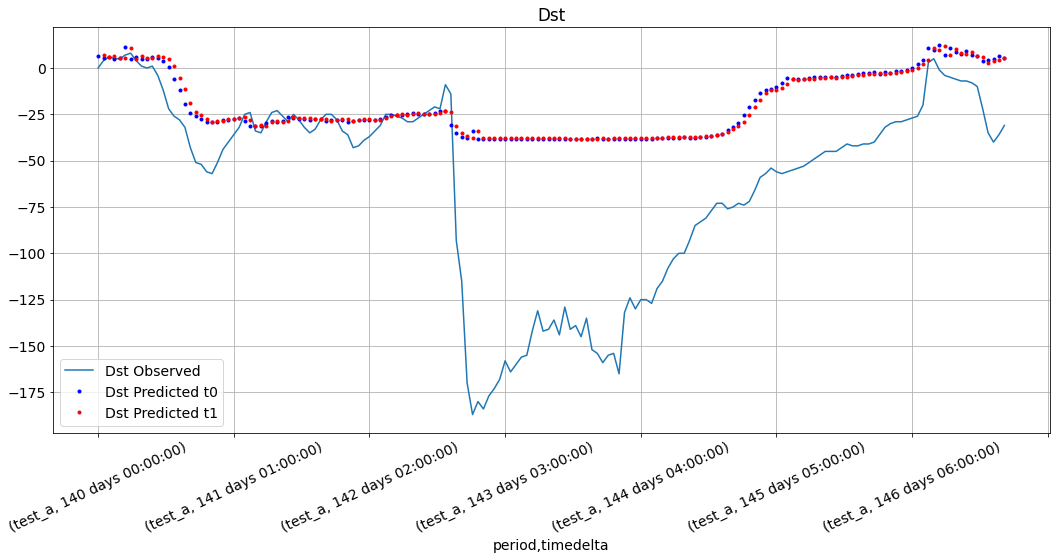

In [46]:
# Dst Observed
ax = dst['dst'][idx_event_1hr].plot(title='Dst', rot=25, figsize=(15, 8), fontsize=14, label='Dst Observed')

# Dst Predicted at t0 and t1
#      Shift Dst[t1] to the right one hour to line up with the time axis
ax.plot(dst_predicted_t0, 'b.', label='Dst Predicted t0')
ax.plot(np.concatenate(([np.nan],dst_predicted_t1[:-1])), 'r.', label='Dst Predicted t1')
plt.grid(True)
plt.legend(fontsize=14)
plt.tight_layout()

In [47]:
''' Uncomment this block if you want to plot just the Dst predictions.
# Dst Predicted
fig = plt.figure(figsize=(15, 8))

plt.plot(dst_predicted_t0, 'b', label='Dst Predicted t0')
plt.plot(dst_predicted_t1, 'r', label='Dst Predicted t1')
plt.grid(True)
plt.legend(fontsize=14)
plt.title('Dst Predicted')

plt.tight_layout()
'''

" Uncomment this block if you want to plot just the Dst predictions.\n# Dst Predicted\nfig = plt.figure(figsize=(15, 8))\n\nplt.plot(dst_predicted_t0, 'b', label='Dst Predicted t0')\nplt.plot(dst_predicted_t1, 'r', label='Dst Predicted t1')\nplt.grid(True)\nplt.legend(fontsize=14)\nplt.title('Dst Predicted')\n\nplt.tight_layout()\n"

## Student Exercise: Additional Case Studies and Degraded Data

<div class="alert alert-block alert-warning">
<b>Optional Task: </b>Look at the CNN notebook (magnet_cnn_tutorial.ipynb) and add additional events here and compare the LSTM and CNN performance for each event.

<div class="alert alert-block alert-info">
<b>Questions: </b>
    
- Are there storm events where LSTM is close to performing as well as the CNN model (see magnet_cnn_tutorial.ipynb)?
- Are there phases or characteristics of different storm events where LSTM or CNN do better than each other?

You can use these storm phase descriptions for contextualizing your findings:
- Climatology / quiet periods: <i>Dst</i> is generally horizontal and nearly 0 nano-Tesla.
- Sudden Impulse: <i>Dst</i> rises from near 0 to positive values rapidly over a few hours. 
- Storm Sudden Commencement and Main Phase: <i>Dst</i> drops sharply and remains significantly negative for up to several days.
- Storm Peak: <i>Dst</i> reaches it's minmum (most negative) value.
- Recovery Phase: <i>Dst</i> recovers from large negative values back to climatology, near 0 nano-Tesla.
    
</div>

<div class="alert alert-block alert-info">
<i>You can use this empty cell to write down your thoughts regarding the preceding question(s).</i>
</div>

## Student Exercise: Degraded or Adverserial Data - How robust is the model?

<div class="alert alert-block alert-warning">
<b>Optional Task: </b>Students: Here's your chance to degrade the instrument measurements and run the model to see how the performance is impacted. Start simple by adding Gaussian noise (mean 0), to the least important and the most important input parameters (aka features) and evaluating a specific event. You could also fold in the SHAP methodology here.
</div>

<div class="alert alert-block alert-info">
<b>Questions: </b>

1. Thinking about your predictions from yesterday, if you degrade the data for one or more input parameters (features) by adding Gaussian noise, how does that impact the model performance to predict <i>Dst</i>?
2. Based on what you learned in the lectures and your review of these case studies, what would you show your end user if they asked for a case study? How would you do this? 
</div>

<div class="alert alert-block alert-info">
<i>You can use this empty cell to write down your thoughts regarding the preceding question(s).</i>
</div>

## Disclaimer

The United States Department of Commerce (DOC) GitHub project code is provided on an ‘as is’ basis and the user assumes responsibility for its use. DOC has relinquished control of the information and no longer has responsibility to protect the integrity, confidentiality, or availability of the information. Any claims against the Department of Commerce stemming from the use of its GitHub project will be governed by all applicable Federal law. Any reference to specific commercial products, processes, or services by service mark, trademark, manufacturer, or otherwise, does not constitute or imply their endorsement, recommendation or favoring by the Department of Commerce. The Department of Commerce seal and logo, or the seal and logo of a DOC bureau, shall not be used in any manner to imply endorsement of any commercial product or activity by DOC or the United States Government.

